In [1]:
# Importing libraries
from typing import List, Tuple, Dict, List
import numpy as np

In [2]:
class VectorModel:
    
    def __init__(self, vector_dict: Dict[str, np.ndarray]):
        self.index = dict()
        self.reverse_index = dict()
        arrays = []
        for idx, item in enumerate(vector_dict.items()):
            word, vec = item
            arrays.append(vec)
            self.index[word] = idx
            self.reverse_index[idx] = word
        self.embeddings = np.stack(arrays)
        
    def embed(self, word: str) -> np.ndarray:
        if word in self.index:
            return self.embeddings[self.index[word]]
    
    def vector_size(self) -> int:
        return self.embeddings.shape[1]
    
    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    def most_similar(self, word: str, top_n: int=5) -> List[Tuple[str, float]]:
        if word not in self.index:
            return None
        
        sims = []
        for idx in range(len(self.index)):
            sims.append(self.cosine_similarity(self.embed(word), self.embeddings[idx]))
        sim = np.array(sims)
        top_n += 1
        topn_indices = list(np.argpartition(sims, -top_n)[-top_n:])
        if self.index[word] in topn_indices:
            topn_indices.remove(self.index[word])
        else:
            topn_indices = topn_indices[:-1]
        
        result = []
        for idx in topn_indices:
            result.append((self.reverse_index[idx], sim[idx]))
        return sorted(result, key=lambda x: -x[1])
        
    def most_similar_vec(self, vec: np.ndarray, top_n: int=5) -> List[Tuple[str, float]]:
       
        sims = []
        for idx in range(len(self.index)):
            sims.append(self.cosine_similarity(vec, self.embeddings[idx]))
        sim = np.array(sims)
        topn_indices = list(np.argpartition(sims, -top_n)[-top_n:])
        
        result = []
        for idx in topn_indices:
            result.append((self.reverse_index[idx], sim[idx]))
        return sorted(result, key=lambda x: -x[1])

In [46]:
class SemanticAxis:
    
    def __init__(self, words, model: VectorModel):
        """
        Args:
            embedding_dict (Dict[str, np.ndarray]) - A dictionary of embedding vectors
        """
        self.model = model
        self.words = words
        self.axis = 0
        self.mean = 0
        self.std = 0

    def cosine_similarity(self, vec1: np.ndarray, vec2: np.ndarray) -> float:
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def fit(
            self, 
            positive_seeds: List[str],
            negative_seeds: List[str]):
        """
        Args:
            positive_seeds (Dict[str, np.ndarray]) - A dictionary of embedding vectors
        """
        positive_centroid = np.array([self.model[seed] for seed in positive_seeds]).sum(axis=0)
        negative_centroid = np.array([self.model[seed] for seed in negative_seeds]).sum(axis=0)
        
        self.axis = positive_centroid - negative_centroid
        
        scores = dict()
        words_to_remove = []

        for token in self.words:
            # print(token)
            # scores[token] = self.model.cosine_similarity(axis, self.model.embed(token))
            try:
                vector = self.model[token]
                scores[token] = self.cosine_similarity(self.axis, vector)
            except KeyError:
                words_to_remove.append(token)
                continue
        
        # Remove words without embeddings
        for word in words_to_remove:
            self.words.remove(word)

        # Make sure scores have zero mean and unit variance
        self.mean = np.mean(list(scores.values()))
        self.std = np.std(list(scores.values()))
        
        return {
            token: (score - self.mean) / self.std
            for token, score in scores.items()
        }

    def word_sentiment(self, word):
        """ Evaluate whether the word is sarcastic or not
        """
        try:
            vector = self.model[word]
            score = (self.cosine_similarity(self.axis, vector) - self.mean)/self.std
            verdict = 'Likely sarcastic' if score>0 else 'Likely non-sarcastic'
            return (verdict,score)
        except KeyError:
            print('Word embedding not found')
            return ('uncertain', 0)

In [5]:
# ! python -m gensim.downloader --info

In [30]:
import gensim.downloader as api
# Download Word2Vec embeddings
model = api.load('word2vec-google-news-300')
model_name = 'Word2Vec'
# Download glove embeddings
# model = api.load('glove-twitter-200')
# model_name = 'Glove'

In [8]:
vec_sample = model['sample']
# model.similarity(w1, w2)
# model.most_similar(positive=['car', 'minivan'], topn=5)
# model.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])
# print(type(vec_sample), vec_sample.shape, vec_sample)

### Semantic Axis
##### Twitter dataset 

In [78]:
import json
dataset = 'iSarcasmEval'
with open('../outputs/' + dataset + '.json') as file:
    data = json.load(file)
num_words = len(data)
print(type(data), num_words)

<class 'dict'> 399


In [57]:
# Defining number of seeds
num_seeds = int(np.ceil(num_words * 0.01))
# Sorting all keywords to a list
sorted_data = [(key, val) for key, val in sorted(data.items(), key = lambda ele: ele[1])]
sorted_words = [elem[0] for elem in sorted_data]
print(type(sorted_data), len(sorted_data))

<class 'list'> 399


In [32]:
# Get sarcastic and non-sarcastic seeds
non_sarcastic_seeds = []
idx = 0
while(len(non_sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[idx][0]]
        non_sarcastic_seeds.append(sorted_data[idx][0])
    except:
        KeyError
    idx += 1

sarcastic_seeds = []
idx = 0
while(len(sarcastic_seeds)<num_seeds):
    try:
        _ = model[sorted_data[num_words - idx -1][0]]
        sarcastic_seeds.append(sorted_data[num_words - idx -1][0])
    except KeyError:
        pass # do nothing
    idx += 1

# non_sarcastic_seeds = [sorted_data[idx][0] for idx in range(num_seeds)]
print(f"Negative  Seeds: {non_sarcastic_seeds}")
# sarcastic_seeds = [sorted_data[num_words - idx -1][0] for idx in range(num_seeds)]
print(f"Positive  Seeds: {sarcastic_seeds}")

Negative  Seeds: ['kinda', 'want', 'miss', 've']
Positive  Seeds: ['love', 'wait', 'decide', 'poor']


In [41]:
help(model.distance)
# add_vector
# add_vectors
# cosine_similarities
# distance
# distances
# most_similar
# most_similar_cosmul
# most_similar_to_given
# n_similarity
# similar_by_key
# similar_by_vector
# similar_by_word
# wm_distance

Help on method distance in module gensim.models.keyedvectors:

distance(w1, w2) method of gensim.models.keyedvectors.KeyedVectors instance
    Compute cosine distance between two keys.
    Calculate 1 - :meth:`~gensim.models.keyedvectors.KeyedVectors.similarity`.
    
    Parameters
    ----------
    w1 : str
        Input key.
    w2 : str
        Input key.
    
    Returns
    -------
    float
        Distance between `w1` and `w2`.



In [58]:
print(f"Creating semantic axis using {model_name} embeddings")
semantic_model = SemanticAxis(sorted_words, model)
sentiment_w2v_axis = semantic_model.fit(sarcastic_seeds, non_sarcastic_seeds)

Creating semantic axis using Glove embeddings


In [60]:
num_samples = 5
interval = int(np.floor(len(semantic_model.words)/5))
sample_words = [semantic_model.words[max(i-1, 0)] for i in range(0, len(semantic_model.words), interval)]

[-3.7915757, 0.7233091, -1.2690088, -0.70320016, -1.8199475, 3.0517087]


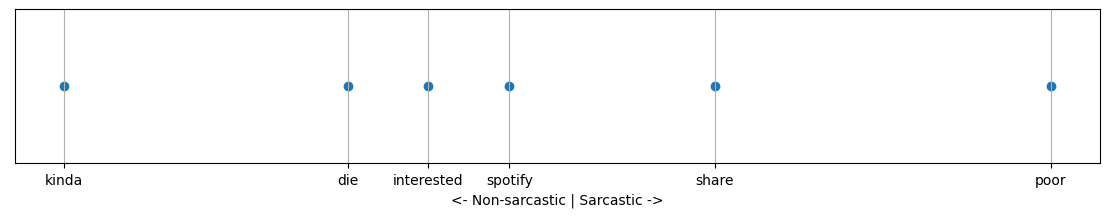

In [83]:
# Plotting the examples
import matplotlib.pyplot as plt
sarcasm_evaluations = [semantic_model.word_sentiment(word) for word in sample_words]
scores = [res[1] for res in sarcasm_evaluations]
# scores = [sentiment_w2v_axis[word] for word in sample_words]
y = [1] * len(scores)
print(scores)
plt.figure(figsize=(14,2))
plt.xlabel('<- Non-sarcastic | Sarcastic ->')
plt.scatter(scores, y)
plt.yticks([])
plt.xticks(scores, labels= sample_words)
plt.grid()
plt.savefig('../outputs/'+"_".join([dataset, model_name, 'semantic_axis'])+'.pdf', bbox_inches='tight')
plt.show()

[10, 10]